# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Data](#5.4_Load_Data)
  * [5.5 Dummy Model](#5.5_Dummy_Model)
  * [5.6 Decision Tree Classifier Model](#5.6_Decision_Tree_Classifier_Model)
  * [5.7 Logistic Regression](#5.7_Logistic_Regression)
      * [5.7.1 Basic Logistic Regression Model](#5.7.1_Basic_Logistic_Regression_Model)
      * [5.7.2 Logistic Regression with Hyperparameter Tuning](#5.7.2_Logistic_Regression_with_Hyperparameter_Tuning)
  * [5.8 Random Forest](#5.8_Random_Forest)
      * [5.8.1 Basic Random Forest Model](#5.8.1_Basic_Random_Forest_Model)
      * [5.8.2 Random Forest with Hyperparameter Tuning](#5.8.2_Random_Forest_with_Hyperparameter_Tuning)
  * [5.9 XGBoost](#5.9_XGBoost)
  * [5.10 Determine Best Model Performance](#5.10_Determine_Best_Model_Performance)
  * [5.11 Holdout Predictions](#5.11_Holdout_Predictions)
      * [5.11.1 Re-train Model](#5.11.1_Re-train_Model)
      * [5.11.2 Predict on Holdout](#5.11.2_Predict_on_Holdout)
  * [5.12 Summary](#5.12_Summary)

## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, I am going to choose a model to predict whether a loan will default. Then I will test my chosen model on the hold-out set. 

## 5.3 Imports<a id='5.3_Imports'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## 5.4 Load Data<a id='5.4_Load_Data'></a>

In [2]:
X_train = loadtxt('../data/X_train.csv', delimiter=',')
X_test = loadtxt('../data/X_test.csv', delimiter=',')
y_train = loadtxt('../data/y_train.csv', delimiter=',')
y_test = loadtxt('../data/y_test.csv', delimiter=',')

In [3]:
X = pd.read_csv('../data/features.csv', index_col = 'id')
y = pd.read_csv('../data/labels.csv', index_col = 'id')

In [4]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## 5.5 Dummy Model<a id='5.5_Dummy_Model'></a>

First I am going to define a function for displaying the classification report and confusion matrix for each of the models.

In [5]:
# adapted from https://gist.github.com/rajaraghav/43dc6ee38d8db48dfa47b3505d0b8a2b
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [6]:
dummy = DummyClassifier(strategy = 'most_frequent', random_state=121)
dummy.fit(X, y)

DummyClassifier(random_state=121, strategy='most_frequent')

In [7]:
dummy.score(X, y)

0.9554118918760107

.score is calculating the accuracy of the model. This score of 0.95 shows exactly why accuracy cannot be used for this dataset. The percentage of defaults in this data is approximately 5%. So, even with this dummy model which is predicting no loan defaults, it is accurate 94.7% of the time. 

For loan defaults, we care about minimizing both false positives and false negatives. Predicting false positives means that lenders will not loan money to borrowers who would have actually paid back the loan. This loses money for the banks and lenders. Predicting false negatives means that the borrow will be lent money that will not be paid back, and also loses the bank money.

The metrics that I will use to assess my model is the f1 score and the confusion matrix.

In [8]:
f1_score(y, dummy.predict(X))

0.0

Above, the f1 score is zero. This is exactly as expected and shows that this dummy model is useless for predicting loan defaults.

## 5.6 Decision Tree Classifier Model<a id='5.6_Decision_Tree_Classifier_Model'></a>

In [9]:
tree = DecisionTreeClassifier(criterion='gini')
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [10]:
y_pred_tree_train = tree.predict(X_train)

In [11]:
y_pred_tree = tree.predict(X_test)

In [12]:
print_score(y_train, y_pred_tree_train, train=True)

Train Result:
CLASSIFICATION REPORT:
                  0         1  accuracy  macro avg  weighted avg
precision       1.0       1.0       1.0        1.0           1.0
recall          1.0       1.0       1.0        1.0           1.0
f1-score        1.0       1.0       1.0        1.0           1.0
support    364210.0  109263.0       1.0   473473.0      473473.0
_______________________________________________
Confusion Matrix: 
 [[364210      0]
 [     0 109263]]



In [13]:
print_score(y_test, y_pred_tree, train=False)

Test Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.964166      0.152194  0.903078       0.558180       0.927961
recall          0.933240      0.256795  0.903078       0.595018       0.903078
f1-score        0.948451      0.191118  0.903078       0.569785       0.914683
support    234137.000000  10927.000000  0.903078  245064.000000  245064.000000
_______________________________________________
Confusion Matrix: 
 [[218506  15631]
 [  8121   2806]]



This basic decision tree model is obviously overfitting to the training data and is not performing well for the test set. Let's see if there is a better model. 

## 5.7 Logistic Regression<a id='5.7_Logistic_Regression'></a>

### 5.7.1 Basic Logistic Regression Model<a id='5.7.1_Basic_Logistic_Regression_Model'></a>

To run the basic logistic regression model, I need to first dummy encode the categorical variables. The X, y data is the features and labeled data before being split into training and test sets. 

In [14]:
for col in ['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'earliest_cr_line_year', 
            'last_credit_pull_d_year']:
    X[col] = X[col].astype('category')

In [15]:
X = pd.get_dummies(X, drop_first=True)
X.shape

(816877, 191)

In [16]:
XD, XD_test, yD, yD_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [17]:
yD = yD.to_numpy().ravel().astype(int)
yD_test = yD_test.to_numpy().ravel().astype(int)

In [18]:
steps = [('scaler', MinMaxScaler()),
        ('logreg', LogisticRegression(max_iter=500))]
pipeline_logreg = Pipeline(steps)
pipeline_logreg.fit(XD, yD)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logreg', LogisticRegression(max_iter=500))])

In [19]:
y_pred_logreg_train = pipeline_logreg.predict(XD)
print_score(yD, y_pred_logreg_train, train=True)

Train Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.956277      0.509896  0.955449       0.733087       0.936374
recall          0.999048      0.021219  0.955449       0.510134       0.955449
f1-score        0.977195      0.040743  0.955449       0.508969       0.935440
support    546317.000000  25496.000000  0.955449  571813.000000  571813.000000
_______________________________________________
Confusion Matrix: 
 [[545797    520]
 [ 24955    541]]



In [20]:
y_pred_logreg = pipeline_logreg.predict(XD_test)
print_score(yD_test, y_pred_logreg, train=False)

Test Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.956296      0.535147  0.955538       0.745722       0.937518
recall          0.999124      0.021598  0.955538       0.510361       0.955538
f1-score        0.977241      0.041520  0.955538       0.509381       0.935519
support    234137.000000  10927.000000  0.955538  245064.000000  245064.000000
_______________________________________________
Confusion Matrix: 
 [[233932    205]
 [ 10691    236]]



In [21]:
print('The basic Logistic Regression test AUC is: ', roc_auc_score(yD_test, y_pred_logreg))

The basic Logistic Regression test AUC is:  0.5103611605272644


The scores for the basic logistic regression model are similar to the basic decision tree but much more consistant between the training predictions and the test predictions. I am going to try to do some hyperparameter tuning to see if I can improve this model.

### 5.7.2 Logistic Regression with Hyperparameter Tuning<a id='5.7.2_Logistic_Regression_with_Hyperparameter_Tuning'></a>

This hyperparameter tuning was adapted from - https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

In [22]:
# define models and parameters
steps = [('scaler', MinMaxScaler()),
        ('logreg', LogisticRegression(max_iter=1000))]

pipeline = Pipeline(steps)

logreg_grid = {
    'logreg__solver': ['lbfgs', 'saga'],
    'logreg__C': [0.1, 0.01, 0.009],
    'logreg__class_weight': ['balanced', None]
}

# define grid search
lr_grid_search = GridSearchCV(estimator=pipeline, param_grid=logreg_grid, n_jobs=-1, cv=3, scoring='precision_macro',error_score=0)
lr_grid_result = lr_grid_search.fit(XD, yD)

In [23]:
lr_grid_search.best_params_

{'logreg__C': 0.009, 'logreg__class_weight': None, 'logreg__solver': 'lbfgs'}

In [24]:
lr_grid_pred_train = lr_grid_search.predict(XD)
print_score(yD, lr_grid_pred_train, train=True)

Train Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.955957      0.605405  0.955617       0.780681       0.940326
recall          0.999599      0.013179  0.955617       0.506389       0.955617
f1-score        0.977291      0.025796  0.955617       0.501543       0.934866
support    546317.000000  25496.000000  0.955617  571813.000000  571813.000000
_______________________________________________
Confusion Matrix: 
 [[546098    219]
 [ 25160    336]]



In [25]:
lr_grid_pred = lr_grid_search.predict(XD_test)
print_score(yD_test, lr_grid_pred, train=False)

Test Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.955906      0.579646  0.955559       0.767776       0.939129
recall          0.999594      0.011989  0.955559       0.505791       0.955559
f1-score        0.977262      0.023491  0.955559       0.500377       0.934735
support    234137.000000  10927.000000  0.955559  245064.000000  245064.000000
_______________________________________________
Confusion Matrix: 
 [[234042     95]
 [ 10796    131]]



In [26]:
print('The tuned Logistic Regression test AUC is: ', roc_auc_score(yD, lr_grid_pred_train))

The tuned Logistic Regression test AUC is:  0.5063888358230343


In [27]:
print('The tuned Logistic Regression training AUC is: ', roc_auc_score(yD_test, lr_grid_pred))

The tuned Logistic Regression training AUC is:  0.5057914533044059


This tuned model does not perform any better than the basic logistic regression model. While these models do not perform well, they are predicting more true positives (defaulted loans) than false positives. The model that is chosen will need to predict more true positives than false because otherwise, it would not make business sense to deploy the model. If the model predicts more false positives than true positives, Lending Club would lose more money by rejecting loan applications than they would for defaulted loans. 

## 5.8 Random Forest<a id='5.8_Random_Forest'></a> 

Next, I am going to see if random forest can give better predictions than logistic regression.

### 5.8.1 Basic Random Forest Model<a id='5.8.1_Basic_Random_Forest_Model'></a> 

In [28]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

y_tr_pred = rf_clf.predict(X_train)
y_t_pred = rf_clf.predict(X_test)

In [29]:
print_score(y_train, y_tr_pred, train=True)
print_score(y_test, y_t_pred, train=False)

Train Result:
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.999995       1.000000  0.999996       0.999997   
recall          1.000000       0.999982  0.999996       0.999991   
f1-score        0.999997       0.999991  0.999996       0.999994   
support    364210.000000  109263.000000  0.999996  473473.000000   

            weighted avg  
precision       0.999996  
recall          0.999996  
f1-score        0.999996  
support    473473.000000  
_______________________________________________
Confusion Matrix: 
 [[364210      0]
 [     2 109261]]

Test Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.962081      0.383024   0.95089       0.672552       0.936262
recall          0.987520      0.166011   0.95089       0.576765       0.950890
f1-score        0.974635      0.231629   0.95089       0.603132       0.941505
support    234137.000000  10927

In [30]:
print('The Basic RF test AUC is: ', roc_auc_score(y_test, y_t_pred))

The Basic RF test AUC is:  0.5767654630217403


The basic Random Forest model is predicting more false positives in the test set than true positives. I will try to do some hyperparameter tuning to see if it could do better.

### 5.8.2 Random Forest with Hyperparameter Tuning<a id='5.8.2_Random_Forest_with_Hyperparameter_Tuning'></a>

The following random forest hyperparameter tuning was taken from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [31]:
# Number of trees in random forest
n_estimators = [100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 17, 25, 32, 40, None], 'min_samples_split': [2, 4], 'bootstrap': [True, False]}


In [32]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf2 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf2_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 15, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='precision_macro')
# Fit the random search model
rf2_random.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 17, 25, 32, 40, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': [100, 200]},
                   random_state=42, scoring='precision_macro', verbose=2)

In [33]:
rf2_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [34]:
y_train_pred_forest2 = rf2_random.best_estimator_.predict(X_train)
y_test_pred_forest2 = rf2_random.best_estimator_.predict(X_test)

In [35]:
print_score(y_train, y_train_pred_forest2, train=True)
print_score(y_test, y_test_pred_forest2, train=False)

Train Result:
CLASSIFICATION REPORT:
                  0         1  accuracy  macro avg  weighted avg
precision       1.0       1.0       1.0        1.0           1.0
recall          1.0       1.0       1.0        1.0           1.0
f1-score        1.0       1.0       1.0        1.0           1.0
support    364210.0  109263.0       1.0   473473.0      473473.0
_______________________________________________
Confusion Matrix: 
 [[364210      0]
 [     0 109263]]

Test Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.961347      0.400000  0.952127       0.680673       0.936317
recall          0.989686      0.147341  0.952127       0.568513       0.952127
f1-score        0.975310      0.215356  0.952127       0.595333       0.941425
support    234137.000000  10927.000000  0.952127  245064.000000  245064.000000
_______________________________________________
Confusion Matrix: 
 [[231722   2415]
 [  9317   1610]]


In [36]:
print('The tuned RF test AUC is: ', roc_auc_score(y_test, y_test_pred_forest2))

The tuned RF test AUC is:  0.5685134868926713


The hyperparameter tuning of the Random Forest model did not improve on the performance of the basic model. I am going to try XGBoost next. 

## 5.9 XGBoost<a id='5.9_XGBoost'></a>

In [37]:
# Create the parameter grid: xgb_param_grid 
xgb_param_grid = {
    'objective': ['reg:logistic'],
    'colsample_bytree': [0.3, 0.7, 0.8],
    'n_estimators': [35, 50],
    'max_depth': [7, 10, 15],
    'eta': [0.01, 0.1, 0.2, 0.3],
}

# Instantiate the regressor: xgb
xgb_cl = xgb.XGBClassifier(eval_metric='aucpr', use_label_encoder=False)

# Perform random search: grid_xgb
grid_xgb = GridSearchCV(xgb_cl, param_grid=xgb_param_grid, cv=3, verbose=1, scoring="precision_macro")

In [38]:
# Fit grid_xgb to the data
grid_xgb.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_xgb.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters found:  {'colsample_bytree': 0.3, 'eta': 0.1, 'max_depth': 15, 'n_estimators': 35, 'objective': 'reg:logistic'}


In [39]:
y_train_pred = grid_xgb.predict(X_train)
y_test_pred = grid_xgb.predict(X_test)

In [40]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.933538       0.999748  0.945194       0.966643   
recall          0.999942       0.762701  0.945194       0.881322   
f1-score        0.965600       0.865283  0.945194       0.915442   
support    364210.000000  109263.000000  0.945194  473473.000000   

            weighted avg  
precision       0.948817  
recall          0.945194  
f1-score        0.942450  
support    473473.000000  
_______________________________________________
Confusion Matrix: 
 [[364189     21]
 [ 25928  83335]]

Test Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.955605      0.629630  0.955497       0.792617       0.941070
recall          0.999872      0.004667  0.955497       0.502270       0.955497
f1-score        0.977237      0.009266  0.955497       0.493252       0.934077
support    234137.000000  10927

In [41]:
print('The XGBoost training AUC is: ', roc_auc_score(y_train, y_train_pred))

The XGBoost training AUC is:  0.8813216733935549


In [42]:
print('The XGBoost test AUC is: ', roc_auc_score(y_test, y_test_pred))

The XGBoost test AUC is:  0.5022696038376375


XGBoost is performing similarly to the logistic regression models.  

## 5.10 Determine Best Model Performance<a id='5.10_Determine_Best_Model_Performance'></a>

To determine the best model performance, I am going to plot each of the test ROCs and see which model performed best.

Logistic Regression:
lr_grid_pred
lr_grid_pred_train

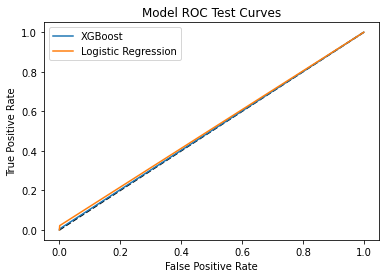

In [43]:
# Plot the ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
fpr1, tpr1, thresholds1 = roc_curve(yD_test, y_pred_logreg)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='XGBoost')
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Model ROC Test Curves')
plt.show()

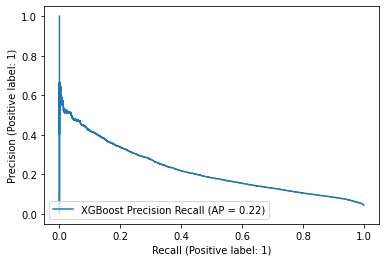

In [48]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(grid_xgb, X_test, y_test, name='XGBoost Precision Recall')

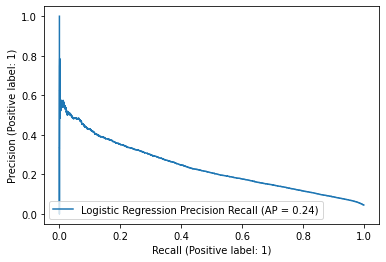

In [49]:
plot_precision_recall_curve(pipeline_logreg, XD_test, yD_test, name='Logistic Regression Precision Recall')

Based on the ROC curves and the precision recall curves, I am going to train the logistic regression model on all of the data and then use that model to predict the holdout set. 

## 5.11 Holdout Predictions<a id='5.11_Holdout_Predictions'></a>

In [50]:
X_holdout = pd.read_csv('../holdout_data/X_holdout.csv', index_col='id')
y_holdout = pd.read_csv('../holdout_data/y_holdout.csv')

y_holdout.drop('id', axis=1, inplace=True)

In [51]:
y_holdout = y_holdout.to_numpy().ravel().astype(int)

In [56]:
all_X = pd.read_csv('../data/all_X_df.csv', index_col='id')
all_y = pd.read_csv('../data/all_y_df.csv')

all_y.drop('id', axis=1, inplace=True)

In [57]:
all_y = all_y.to_numpy().ravel().astype(int)

### 5.11.1 Re-train Model<a id='5.11.1_Re-train_Model'></a>

In [58]:
all_X = pd.get_dummies(all_X, drop_first=True)

steps = [('scaler', MinMaxScaler()),
        ('logreg', LogisticRegression(max_iter=500))]

all_data_logreg = Pipeline(steps)
all_data_logreg.fit(all_X, all_y)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logreg', LogisticRegression(max_iter=500))])

### 5.11.2 Predict on Holdout<a id='5.11.2_Predict_on_Holdout'></a>

In [59]:
holdout_prediction = all_data_logreg.predict(X_holdout)

In [60]:
print_score(y_holdout, holdout_prediction, train=False)

Test Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.956463      0.103230  0.877661       0.529847       0.914613
recall          0.912905      0.194375  0.877661       0.553640       0.877661
f1-score        0.934177      0.134845  0.877661       0.534511       0.894970
support    721738.000000  37227.000000  0.877661  758965.000000  758965.000000
_______________________________________________
Confusion Matrix: 
 [[658878  62860]
 [ 29991   7236]]



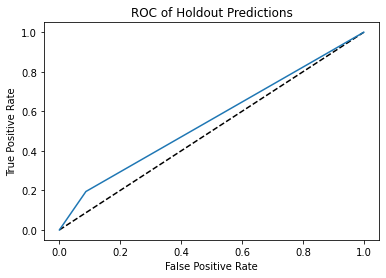

In [65]:
# Plot the ROC curve 
fpr, tpr, thresholds = roc_curve(y_holdout, holdout_prediction)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Holdout Predictions')
plt.show()

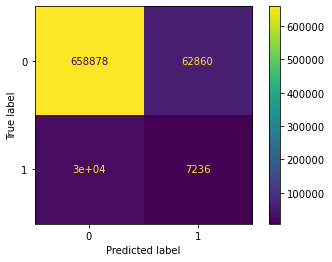

In [66]:
plot_confusion_matrix(all_data_logreg, X_holdout, y_holdout)

## 5.12 Summary<a id='5.12_Summary'></a>

The predictions on the holdout data, using the logistic regression model, are not useful since it predicted approximately 55,000 more false defaults than true defaults. 